In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [6]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_merged = uvel_merged.isel(time=slice(1,110)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(1,110)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [7]:
def lanczos(x, a):
    return np.sinc(x/a)

In [8]:
def nuttall(x, a):
    a=a*2
    return 0.355769+0.487396*np.cos(2*np.pi*x/a)+0.144232*np.cos(4*np.pi*x/a)-0.012604*np.cos(6*np.pi*x/a)

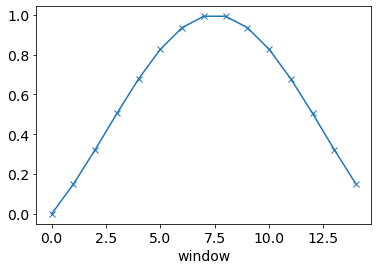

In [9]:
window_width=15
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
weight.plot(marker='x')

In [10]:
nofiles=49
u_eul_filtered = uvel_merged.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
v_eul_filtered = vvel_merged.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_eul_filtered = u_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [11]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,49):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where((ds.u!=-999).all(dim='time'))
        window_width=10
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=3)
        v_piece = windowed_v.sel(time=0).isel(z0=3)
        u_piece2 = ds.u.sel(time=0).isel(z0=3)
        v_piece2 = ds.v.sel(time=0).isel(z0=3)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

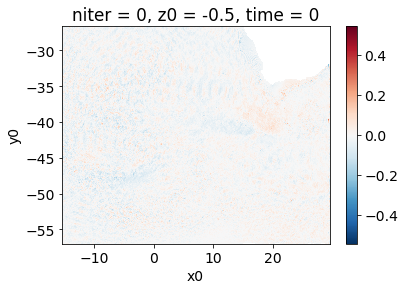

In [13]:
(u_unfiltered-u_filtered).isel(time=0).plot(x='x0')

In [14]:
u_unfiltered.time

<xarray.DataArray 'time' (time: 49)>
array([     0,   3600,   7200,  10800,  14400,  18000,  21600,  25200,  28800,
        32400,  36000,  39600,  43200,  46800,  50400,  54000,  57600,  61200,
        64800,  68400,  72000,  75600,  79200,  82800,  86400,  90000,  93600,
        97200, 100800, 104400, 108000, 111600, 115200, 118800, 122400, 126000,
       129600, 133200, 136800, 140400, 144000, 147600, 151200, 154800, 158400,
       162000, 165600, 169200, 172800])
Coordinates:
    niter    int64 0
    z0       float64 -0.5
  * time     (time) int64 0 3600 7200 10800 ... 162000 165600 169200 172800

In [15]:
#eul_filtered_vels = u_eul_filtered.to_dataset(name='u')
#eul_filtered_vels['v'] = v_eul_filtered
#eul_filtered_vels = eul_filtered_vels.assign_coords({"hFacC":(["j","i"],hFacC.reshape(90,2160,2160)[0,:,:])})
#eul_filtered_vels = eul_filtered_vels.assign_coords({"dxG":(["j_g","i"],DXG.reshape(2160,2160))})
#eul_filtered_vels = eul_filtered_vels.assign_coords({"dyG":(["j","i_g"],DYG.reshape(2160,2160))})
#eul_filtered_vels = eul_filtered_vels.assign_coords(drF = DRF[0])
#eul_filtered_vels.time.attrs['units']='time in seconds'
#eul_filtered_vels.u.attrs['units']='m/s'
#eul_filtered_vels.v.attrs['units']='m/s'
#eul_filtered_vels.j.attrs['long_name']='index in latitude'
#eul_filtered_vels.i.attrs['units']='index_in_longitude'
#eul_filtered_vels.to_zarr('/swot/SUM03/spencer/agulhas_vels/eul_filtered_vels.zarr')

In [16]:
#unfiltered_vels = u_unfiltered.to_dataset(name='u')
#unfiltered_vels['v'] = v_unfiltered
#unfiltered_vels.time.attrs['units']='time in seconds'
#unfiltered_vels.u.attrs['units']='m/s'
#unfiltered_vels.v.attrs['units']='m/s'
#unfiltered_vels.y0.attrs['long_name']='latitude'
#unfiltered_vels.x0.attrs['units']='longitude'
#unfiltered_vels = unfiltered_vels.rename_dims({"x0":"i"})
#unfiltered_vels = unfiltered_vels.rename_dims({"y0":"j"})
#unfiltered_vels.to_zarr('/swot/SUM03/spencer/agulhas_vels/unfiltered_vels.zarr')

In [17]:
#filtered_vels = u_filtered.to_dataset(name='u')
#filtered_vels['v'] = v_filtered
#filtered_vels.time.attrs['units']='time in seconds'
#filtered_vels.u.attrs['units']='m/s'
#filtered_vels.v.attrs['units']='m/s'
#filtered_vels.y0.attrs['long_name']='latitude'
#filtered_vels.x0.attrs['units']='longitude'
#filtered_vels = filtered_vels.rename_dims({"x0":"i"})
#filtered_vels = filtered_vels.rename_dims({"y0":"j"})
#filtered_vels.to_zarr('/swot/SUM03/spencer/agulhas_vels/filtered_vels.zarr')

In [18]:
#plt.figure(figsize=(8,5))
#from matplotlib.colors import LogNorm
#((u_filtered**2+v_filtered**2)/2).where((u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Horizontal KE').plot.pcolormesh(
#        x='x0',y='y0',norm=LogNorm(),vmin=10**-7,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Filtered horizontal KE')
#plt.tight_layout()
#fig = plt.gcf()
#fig.savefig("filtered.png")

In [19]:
#plt.figure(figsize=(8,5))
#from matplotlib.colors import LogNorm
#(((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)/2).where((u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Horizontal KE').plot.pcolormesh(
#        x='x0',y='y0',norm=LogNorm(),vmin=10**-7,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Wave part of horizontal KE')
#plt.tight_layout()
#fig = plt.gcf()
#fig.savefig("wave.png")

In [20]:
#plt.figure(figsize=(8,5))
#from matplotlib.colors import LogNorm
#for tt in range(0,33):
#    plt.clf()
#    ((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2).where(((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)>0).isel(time=tt).rename('Horizontal KE').plot.pcolormesh(
#        x='x0',y='y0',norm=LogNorm(),vmin=10**-7,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
#    plt.xlabel('Longitude')
#    plt.ylabel('Latitude')
#    plt.title('time = ' + '{0:.2f}'.format((u_filtered.time.values[tt]-u_filtered.time.values[0])/3600/24)+ 'days')
#    plt.tight_layout()
#    fig = plt.gcf()
#    fig.savefig("/home/spencerj/agulhas-offline/movie/wave/fig{:03d}.png".format(tt))

In [21]:
#spectrum unfiltered lagrang
with ProgressBar():
    uhat_un = xrft.power_spectrum(u_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat_un = xrft.power_spectrum(v_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
ekehat_un = .5*(uhat_un + vhat_un)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  6min  9.4s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  8min 35.0s


In [14]:
#spectrum_filtered_lagrang
with ProgressBar():
    uhat2 = xrft.power_spectrum(u_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(v_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
ekehat = .5*(uhat2 + vhat2)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  7min 47.2s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 20min 33.1s


In [ ]:
#spectrum_filtered_eul
with ProgressBar():
    uhat2eul = xrft.power_spectrum(u_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2eul = xrft.power_spectrum(v_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
ekehat_eul = .5*(uhat2eul + vhat2eul)

In [16]:
spec0 = int((ekehat['freq_time'].size-1)/2)

In [ ]:
plt.figure(figsize=(10,5))
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).assign_coords(freq_time=ekehat_un.freq_time*3600).mean(['x0','y0'])[spec0:].plot(label='Unfiltered spectrum')
(ekehat_eul*ekehat_eul.freq_time).assign_coords(freq_time=ekehat_eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(ekehat*ekehat.freq_time).assign_coords(freq_time=ekehat.freq_time*3600).mean(['x0','y0'])[spec0:].plot(label='Lagrangian filtered \n spectrum')


plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
plt.legend()
plt.ylim(10**-11,10**-2)
plt.xlim(0.04,2.8)

plt.ylabel('Mean power spectral density \n of horizontal velocity')
plt.xlabel('Frequency (cph)')
plt.title('')

fig = plt.gcf()
fig.savefig("spectrum.png")

In [ ]:
fs = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
fn = 2*2*np.pi/24/3600*np.sin(-30*np.pi/180)
2*np.pi/fn/3600*3

NameError: name 'YC' is not defined

In [34]:
(ekehat_eul*ekehat_eul.freq_time)[spec0+3].mean(['i','j'])

<xarray.DataArray ()>
array(0.00034814)
Coordinates:
    k          int64 0
    freq_time  float64 1.701e-05

In [36]:
(ekehat_un*ekehat_un.freq_time)[spec0+3].mean(['x0','y0'])/0.00035

<xarray.DataArray ()>
array(4.90102615)
Coordinates:
    niter      int64 0
    z0         float64 -0.5
    freq_time  float64 1.701e-05

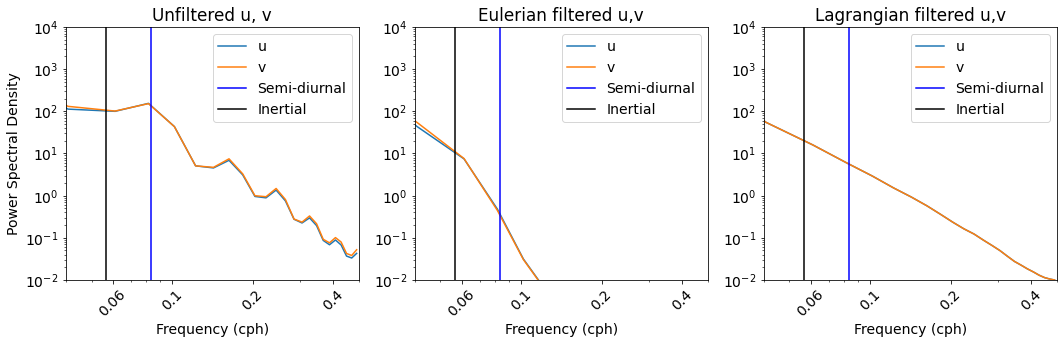

In [18]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(uhat_un.freq_time[spec0:]*3600,uhat_un.mean(['x0','y0'])[spec0:],label='u')
plt.plot(vhat_un.freq_time[spec0:]*3600,vhat_un.mean(['x0','y0'])[spec0:],label='v')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.ylabel('Power Spectral Density')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered u, v')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(uhat2eul.freq_time[spec0:]*3600,uhat2eul.mean(['i','j'])[spec0:],label='u')
plt.plot(vhat2eul.freq_time[spec0:]*3600,vhat2eul.mean(['i','j'])[spec0:],label='v')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered u,v')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(133)
plt.plot(uhat2.freq_time[spec0:]*3600,uhat2.mean(['x0','y0'])[spec0:],label='u')
plt.plot(uhat2.freq_time[spec0:]*3600,uhat2.mean(['x0','y0'])[spec0:],label='v')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered u,v')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('u_filt_unfilt.png')

In [19]:
z_un=u_unfiltered.drop('niter')+1j*v_unfiltered.drop('niter')
with ProgressBar():
    z2_un = xrft.power_spectrum(z_un.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  1min 30.6s


In [20]:
z_f=u_filtered.drop('niter')+1j*v_filtered.drop('niter')
with ProgressBar():
    z2_f = xrft.power_spectrum(z_f.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  3min 49.8s


In [21]:
z_ef=u_eul_filtered+1j*v_eul_filtered
with ProgressBar():
    z2_ef = xrft.power_spectrum(z_ef.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

[                                        ] | 0% Completed |  0.0s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  7.9s


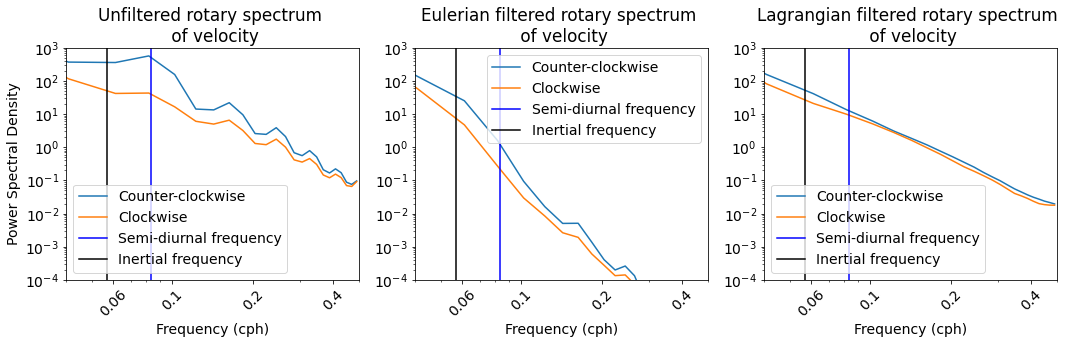

In [70]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(z2_un.freq_time[spec0:]*3600,z2_un.mean(['x0','y0'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_un.freq_time[spec0::-1]*3600,z2_un.mean(['x0','y0'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(z2_ef.freq_time[spec0:]*3600,z2_ef.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_ef.freq_time[spec0::-1]*3600,z2_ef.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(133)
plt.plot(z2_f.freq_time[spec0:]*3600,z2_f.mean(['x0','y0'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_f.freq_time[spec0::-1]*3600,z2_f.mean(['x0','y0'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('Rotary_filt_unfilt.png')

In [17]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})

In [18]:
lons, lats = np.meshgrid(u_filtered.x0.values, u_filtered.y0.values)

In [19]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [20]:
u_eul_resampled = ufunc_resample(u_eul_filtered.load())
v_eul_resampled = ufunc_resample(v_eul_filtered.load())
u_resampled = ufunc_resample(u_filtered.load())
v_resampled = ufunc_resample(v_filtered.load())
u_resampled_unfilt = ufunc_resample(u_unfiltered.load())
v_resampled_unfilt = ufunc_resample(v_unfiltered.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

KeyboardInterrupt: 

In [ ]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [ ]:
with ProgressBar():
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps = (u2_ps + v2_ps)*0.5

In [ ]:
with ProgressBar():
    u2_ps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_unfilt = (u2_ps_unfilt + v2_ps_unfilt)*0.5

In [ ]:
with ProgressBar():
    u2_ps_eul = xrft.power_spectrum(u_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_eul = xrft.power_spectrum(v_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_eul = (u2_ps_eul + v2_ps_eul)*0.5

In [ ]:
u2_wavenumber = xrft.isotropic_power_spectrum(u_resampled, dim=['x1','y1'],window=True)
v2_wavenumber = xrft.isotropic_power_spectrum(v_resampled, dim=['x1','y1'],window=True)

In [ ]:
vel_wavenumber = (u2_wavenumber+v2_wavenumber)*0.5
vel_wavenumber.isel(time=0).plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber(/km)')
plt.tight_layout()

fig=plt.gcf()
fig.savefig('wavenumber.png')

In [ ]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [ ]:
ps_iso = iso_spec(vel_ps)
ps_iso_unfilt = iso_spec(vel_ps_unfilt)
ps_iso_eul = iso_spec(vel_ps_eul)

In [ ]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

In [36]:
omegaM.shape

(129, 6)

Text(0, 0.5, '$\\omega$')

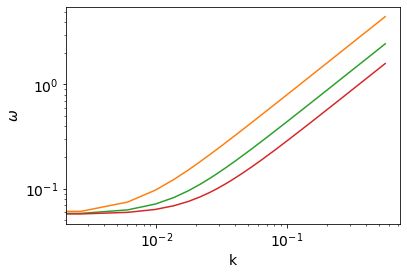

In [37]:
plt.plot(kr, omegaM[:,0:4]/2/np.pi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('$\omega$')

In [38]:
ps_iso_unfilt

<xarray.DataArray (freq_time: 49, kr: 129)>
array([[           nan, 1.82074833e-02, 1.58289231e-03, ...,
        5.47841205e-05, 5.40953124e-05, 9.74553854e-06],
       [           nan, 2.76917921e-02, 1.83620657e-03, ...,
        3.52297684e-05, 3.63417849e-05, 6.22433887e-06],
       [           nan, 2.53105592e-02, 2.48247503e-03, ...,
        4.19258798e-05, 4.73809235e-05, 7.42041972e-06],
       ...,
       [           nan, 2.53105592e-02, 2.48247503e-03, ...,
        4.19258798e-05, 4.73809235e-05, 7.42041972e-06],
       [           nan, 2.76917921e-02, 1.83620657e-03, ...,
        3.52297684e-05, 3.63417849e-05, 6.22433887e-06],
       [           nan, 1.82074833e-02, 1.58289231e-03, ...,
        5.47841205e-05, 5.40953124e-05, 9.74553854e-06]])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001361 -0.0001304 ... 0.0001304 0.0001361
  * kr         (kr) float64 0.0 0.002653 0.006041 ... 0.4921 0.496 0.5611

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


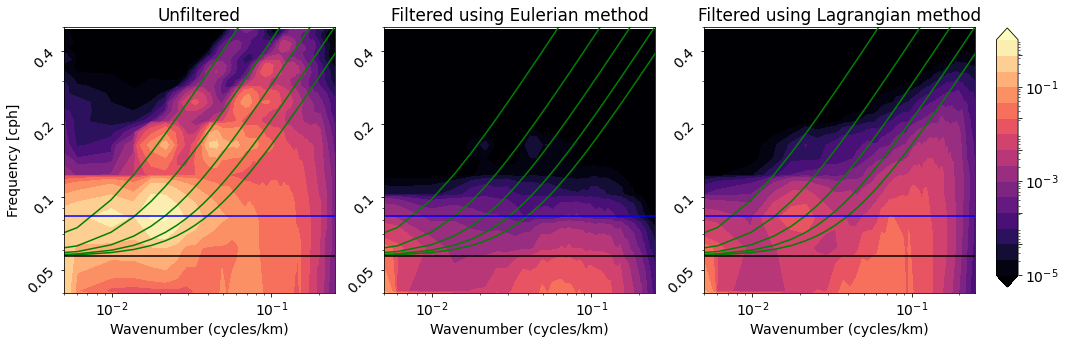

In [40]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Eulerian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Lagrangian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq.png')

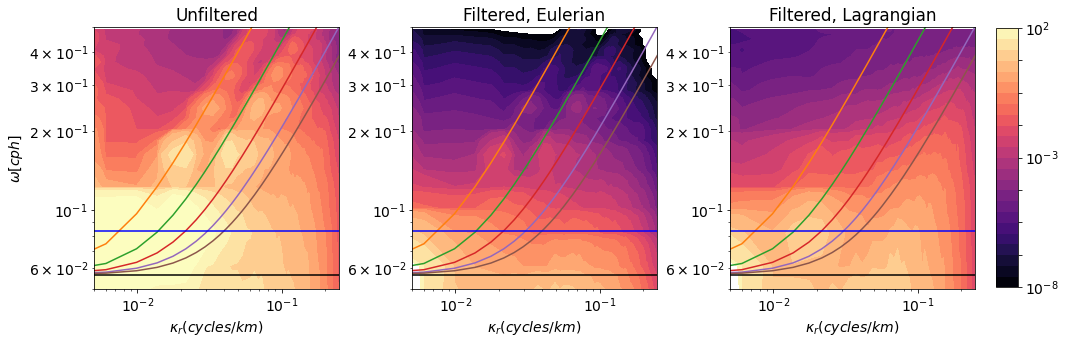

In [71]:
#non variance preserving
plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-8,2,25)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.05, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')

plt.subplot(132)
cs = plt.contourf(kr,omega,ps_iso_eul,lev,norm=LogNorm(), cmap='magma')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.05, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')

plt.subplot(133)
cs = plt.contourf(kr,omega,ps_iso,lev,norm=LogNorm(), cmap='magma')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.05, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')



fig=plt.gcf()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('wavenumber_freq.png')

In [74]:
u2_xps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','time'],window=True,window_correction=True).compute()
u2_xps_eul = xrft.power_spectrum(u_eul_resampled, dim=['x1','time'],window=True,window_correction=True).compute()
u2_xps_f = xrft.power_spectrum(u_resampled, dim=['x1','time'],window=True,window_correction=True).compute()

v2_xps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','time'],window=True,window_correction=True).compute()
v2_xps_eul = xrft.power_spectrum(v_eul_resampled, dim=['x1','time'],window=True,window_correction=True).compute()
v2_xps_f = xrft.power_spectrum(v_resampled, dim=['x1','time'],window=True,window_correction=True).compute()

u2_yps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['y1','time'],window=True,window_correction=True).compute()
u2_yps_eul = xrft.power_spectrum(u_eul_resampled, dim=['y1','time'],window=True,window_correction=True).compute()
u2_yps_f = xrft.power_spectrum(u_resampled, dim=['y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:13: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:19: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:31: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:49: UserWarning: Log scale: values of z <= 0 have been masked
/ho

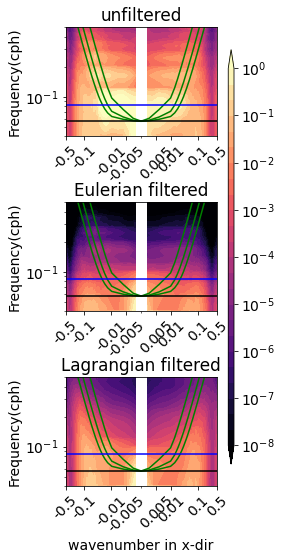

In [75]:

kx = v2_xps_unfilt.freq_x1
omega = v2_xps_unfilt.freq_time*3600
lev_exp = np.linspace(-8,0,25)
lev = np.power(10, lev_exp)
xtick_s = [-0.5,-10**-1,-10**-2,-5*10**-3,5*10**-3,10**-2,10**-1,0.5]


plt.figure(figsize=(4,8))


plt.subplot(311)

cs = plt.contourf(kx,omega,(v2_xps_unfilt*abs(kx)*omega).mean('y1'),lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('')
plt.ylabel('Frequency(cph)')
plt.title('unfiltered')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.subplot(312)

cs = plt.contourf(kx,omega,(v2_xps_eul*abs(kx)*omega).mean('y1'),lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('')
plt.ylabel('Frequency(cph)')
plt.title('Eulerian filtered')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.subplot(313)

cs = plt.contourf(kx,omega,(v2_xps_f*abs(kx)*omega).mean('y1'),lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('Frequency(cph)')
plt.title('Lagrangian filtered')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.78,hspace=0.6)
cbar_ax = fig.add_axes([0.82, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)
fig.savefig('transverse_spectrum_v.png')



/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:33: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:53: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


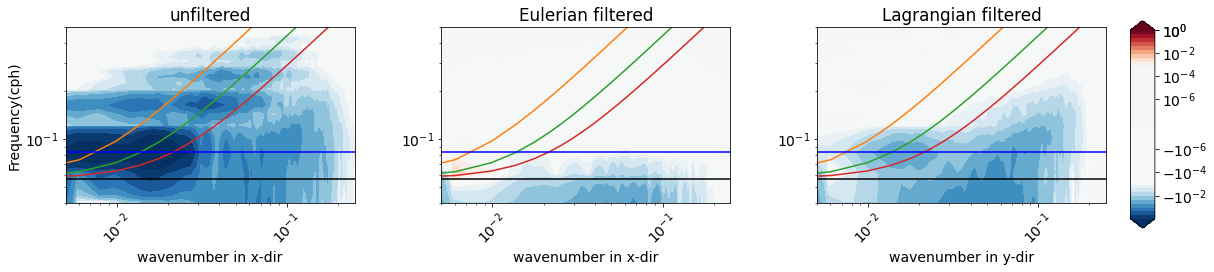

In [76]:
#Plot the asymmetry
from matplotlib import ticker, colors

lev_exp = np.linspace(-8,0,25)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])


plt.figure(figsize=(17,4)) 


plt.subplot(131)
asymm1 = (v2_xps_unfilt*abs(kx)*omega).mean('y1')[:,int(kx.size/2):].values-(v2_xps_unfilt*abs(kx)*omega).mean('y1')[:,int(kx.size/2):0:-1].values
cs = plt.contourf(kx[int(kx.size/2):],omega,asymm1, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('Frequency(cph)')
plt.title('unfiltered')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')


plt.subplot(132)
asymm2 = (v2_xps_eul*abs(kx)*omega).mean('y1')[:,int(kx.size/2):].values-(v2_xps_eul*abs(kx)*omega).mean('y1')[:,int(kx.size/2):0:-1].values
cs = plt.contourf(kx[int(kx.size/2):],omega,asymm2, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('')
plt.title('Eulerian filtered')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.subplot(133)

asymm3 = (v2_xps_f*abs(kx)*omega).mean('y1')[:,int(kx.size/2):].values-(v2_xps_f*abs(kx)*omega).mean('y1')[:,int(kx.size/2):0:-1].values

cs = plt.contourf(kx[int(kx.size/2):],omega,asymm3,levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0), cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('wavenumber in y-dir')
plt.ylabel('')
plt.title('Lagrangian filtered')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.91,wspace=0.3)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])


maxlog=int(np.ceil(np.log10(1)))
minlog=int(np.ceil(np.log10(1)))
logthresh=-3
tick_locations=[10**0, -10**-2, -10**-4, -10**-6,10**-6, 10**-4, 10**-2,10**0]
fig.colorbar(cs, cax=cbar_ax,ticks=tick_locations,format=ticker.LogFormatterMathtext())

fig.savefig('transverse_spectrum_difference.png')

In [77]:

z_un=u_resampled_unfilt+1j*v_resampled_unfilt
z2_psx_unfilt = xrft.power_spectrum(z_un, dim=['x1','time'],window=True,window_correction=True).compute()
z2_psy_unfilt = xrft.power_spectrum(z_un, dim=['y1','time'],window=True,window_correction=True).compute()
z_eul=u_eul_resampled+1j*v_eul_resampled
z2_psx_eul = xrft.power_spectrum(z_eul, dim=['x1','time'],window=True,window_correction=True).compute()
z2_psy_eul = xrft.power_spectrum(z_eul, dim=['y1','time'],window=True,window_correction=True).compute()
z_f=u_resampled+1j*u_resampled
z2_psx_f = xrft.power_spectrum(z_f, dim=['x1','time'],window=True,window_correction=True).compute()
z2_psy_f = xrft.power_spectrum(z_f, dim=['y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:19: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:35: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:43: MatplotlibDeprecationWarning: The 'linthreshy' parameter of _

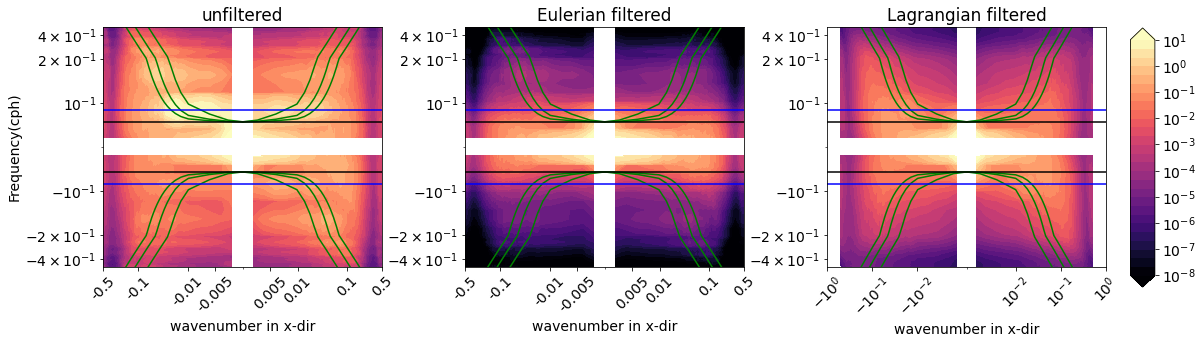

In [78]:
kx = u2_xps_unfilt.freq_x1
omega = u2_xps_unfilt.freq_time*3600
lev_exp = np.linspace(-8,1,28)
lev = np.power(10, lev_exp)
xtick_s = [-0.5,-10**-1,-10**-2,-5*10**-3,5*10**-3,10**-2,10**-1,0.5]

plt.figure(figsize=(17,5))

plt.subplot(131)

cs = plt.contourf(kx,omega,(abs(kx)*abs(omega)*z2_psx_unfilt).mean('y1').T,lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(kr, -omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, -omegaM[:,i]/np.pi/2, label=i,color='g')

plt.yscale('symlog', linthreshy=0.2)
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([-0.5, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('Frequency(cph)')
plt.title('unfiltered')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([-2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(fm/np.pi/2*3600,color='k')

plt.subplot(132)

cs = plt.contourf(kx,omega,(abs(kx)*abs(omega)*z2_psx_eul).mean('y1').T,lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(kr, -omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, -omegaM[:,i]/np.pi/2, label=i,color='g')

plt.yscale('symlog', linthreshy=0.2)
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([-0.5, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('')
plt.title('Eulerian filtered')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([-2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(fm/np.pi/2*3600,color='k')

plt.subplot(133)

cs = plt.contourf(kx,omega,(abs(kx)*abs(omega)*z2_psx_f).mean('y1').T,lev,norm=LogNorm(), cmap='magma',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(kr, -omegaM[:,i]/np.pi/2, label=i,color='g')
    plt.plot(-kr, -omegaM[:,i]/np.pi/2, label=i,color='g')

plt.yscale('symlog', linthreshy=0.2)
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([-0.5, 0.5])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('')
plt.title('Lagrangian filtered')
plt.xticks([-10**0,-10**-1,-10**-2,10**-2,10**-1,10**0],rotation=45)
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([-2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(fm/np.pi/2*3600,color='k')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.91,wspace=0.3)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('rotary_spectrum_x.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:34: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:38: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor re

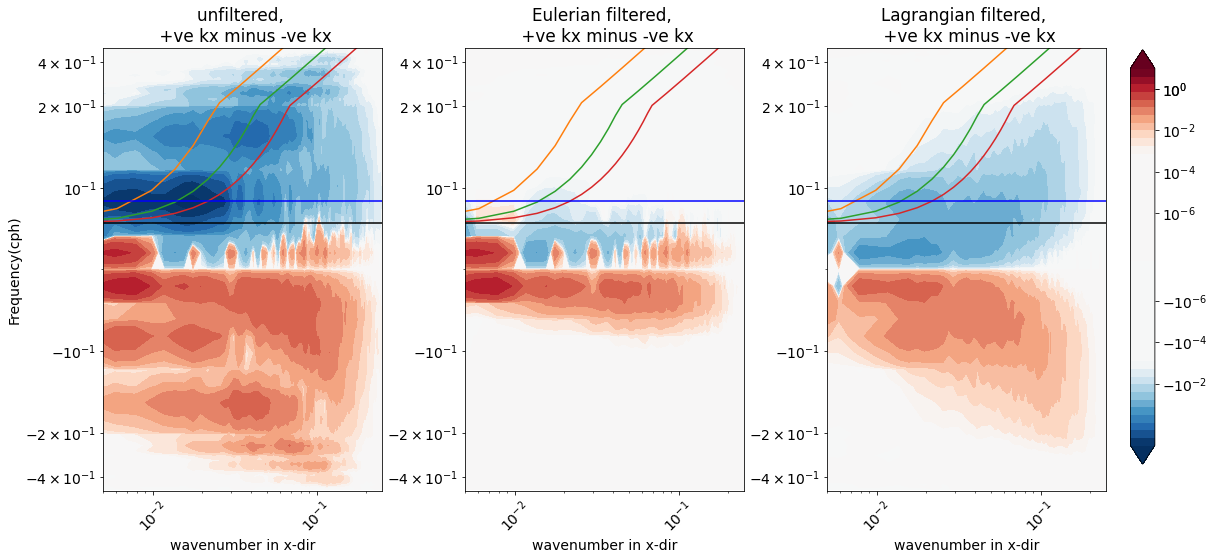

In [86]:
#Plot the asymmetry
from matplotlib import ticker

lev_exp = np.linspace(-8,1,25)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])


plt.figure(figsize=(17,8))


plt.subplot(131)
asymm1 = (abs(kx)*abs(omega)*z2_psx_unfilt).mean('y1')[int(kx.size/2):,:].values-(abs(kx)*abs(omega)*z2_psx_unfilt).mean('y1')[int(kx.size/2):0:-1,:].values
cs = plt.contourf(kx[int(kx.size/2):],omega,asymm1.T, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('symlog', linthreshy=0.2)
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([-0.5, 0.5])
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('Frequency(cph)')
plt.title('unfiltered, \n +ve kx minus -ve kx')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')


plt.subplot(132)
asymm2 = (abs(kx)*abs(omega)*z2_psx_eul).mean('y1')[int(kx.size/2):,:].values-(abs(kx)*abs(omega)*z2_psx_eul).mean('y1')[int(kx.size/2):0:-1,:].values
cs = plt.contourf(kx[int(kx.size/2):],omega,asymm2.T, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('symlog', linthreshy=0.2)
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([-0.5, 0.5])
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('')
plt.title('Eulerian filtered, \n +ve kx minus -ve kx')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.subplot(133)

asymm3 = (abs(kx)*abs(omega)*z2_psx_f).mean('y1')[int(kx.size/2):,:].values-(abs(kx)*abs(omega)*z2_psx_f).mean('y1')[int(kx.size/2):0:-1,:].values
cs = plt.contourf(kx[int(kx.size/2):],omega,asymm3.T,levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10), cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('symlog', linthreshy=0.2)
plt.xscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([-0.5, 0.5])
plt.yticks([-4*10**-1,-2*10**-1,-10**-1,10**-1,2*10**-1,4*10**-1])
plt.xlabel('wavenumber in x-dir')
plt.ylabel('')
plt.title('Lagrangian filtered, \n +ve kx minus -ve kx')
plt.xticks([10**-2,10**-1],rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.91,wspace=0.3)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])


maxlog=int(np.ceil(np.log10(1)))
minlog=int(np.ceil(np.log10(1)))
logthresh=-3
tick_locations=[10**0, -10**-2, -10**-4, -10**-6,10**-6, 10**-4, 10**-2,10**0]
fig.colorbar(cs, cax=cbar_ax,ticks=tick_locations,format=ticker.LogFormatterMathtext())

fig.savefig('rotary_spectrum_diff_x.png')



In [88]:
asymm_test = (abs(kx)*abs(omega)*z2_psx_f).mean('y1')[int(kx.size/2):,int(omega.size/2):-1].values-(abs(kx)*abs(omega)*z2_psx_f).mean('y1')[int(kx.size/2):0:-1,int(omega.size/2):0:-1].values

In [1]:
kr

NameError: name 'kr' is not defined

In [93]:
(abs(kx)*abs(omega)*z2_psx_f).mean('y1')[int(kx.size/2):,int(omega.size/2):-1].values


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.30365665e+01, 3.80963579e-01, ...,
        3.50035366e-07, 3.13089702e-07, 3.00502631e-07],
       [0.00000000e+00, 2.55934203e+00, 4.93052977e-02, ...,
        6.23190052e-07, 6.09555138e-07, 5.92479245e-07],
       ...,
       [0.00000000e+00, 1.19921154e-04, 2.04605449e-04, ...,
        2.28583231e-06, 1.79962844e-06, 1.54765027e-06],
       [0.00000000e+00, 1.23077093e-04, 2.04257283e-04, ...,
        2.14032746e-06, 1.91216695e-06, 1.62591673e-06],
       [0.00000000e+00, 1.33658999e-04, 2.19053158e-04, ...,
        2.14552851e-06, 1.74503094e-06, 1.59337290e-06]])

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:41: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor re

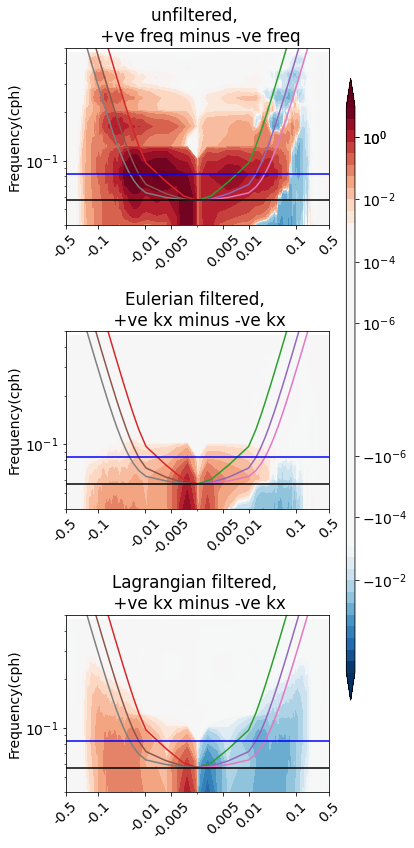

In [146]:
#Plot the asymmetry
from matplotlib import ticker

lev_exp = np.linspace(-8,1,25)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])


plt.figure(figsize=(6,12))


plt.subplot(311)
asymm1 = (abs(kx)*abs(omega)*z2_psx_unfilt).mean('y1')[:,int(omega.size/2):-1].values-(abs(kx)*abs(omega)*z2_psx_unfilt).mean('y1')[:,int(omega.size/2):0:-1].values
cs = plt.contourf(kx,omega[int(omega.size/2):-1],asymm1.T, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])

plt.xlabel('')
plt.ylabel('Frequency(cph)')
plt.title('unfiltered, \n +ve freq minus -ve freq')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')


plt.subplot(312)
asymm2 = (abs(kx)*abs(omega)*z2_psx_eul).mean('y1')[:,int(omega.size/2):-1].values-(abs(kx)*abs(omega)*z2_psx_eul).mean('y1')[:,int(omega.size/2):0:-1].values
cs = plt.contourf(kx,omega[int(omega.size/2):-1],asymm2.T, levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10),cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])
plt.xlabel('')
plt.ylabel('Frequency(cph)')
plt.title('Eulerian filtered, \n +ve kx minus -ve kx')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.subplot(313)

asymm3 = (abs(kx)*abs(omega)*z2_psx_f).mean('y1')[:,int(omega.size/2):-1].values-(abs(kx)*abs(omega)*z2_psx_f).mean('y1')[:,int(omega.size/2):0:-1].values
cs = plt.contourf(kx,omega[int(omega.size/2):-1],asymm3.T,levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-10, vmax=10), cmap='RdBu_r',extend='both')

for i in range(0,4):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i)
    plt.plot(-kr, omegaM[:,i]/np.pi/2, label=i)
plt.yscale('log')
plt.xscale('symlog', linthreshx=0.01)
plt.xlim([-0.25, 0.25])
plt.ylim([0.04, 0.5])

plt.ylabel('Frequency(cph)')
plt.xlabel('')
plt.title('Lagrangian filtered, \n +ve kx minus -ve kx')
plt.xticks(xtick_s,xtick_s,rotation=45)
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axhline(-fm/np.pi/2*3600,color='k')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.78,hspace=0.6)
cbar_ax = fig.add_axes([0.82, 0.18, 0.02, 0.72])


maxlog=int(np.ceil(np.log10(1)))
minlog=int(np.ceil(np.log10(1)))
logthresh=-3
tick_locations=[10**0, -10**-2, -10**-4, -10**-6,10**-6, 10**-4, 10**-2,10**0]
fig.colorbar(cs, cax=cbar_ax,ticks=tick_locations,format=ticker.LogFormatterMathtext())

fig.savefig('rotary_spectrum_diff_t.png')


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:24: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:41: UserWarning: Log scale: values of z <= 0 have been masked


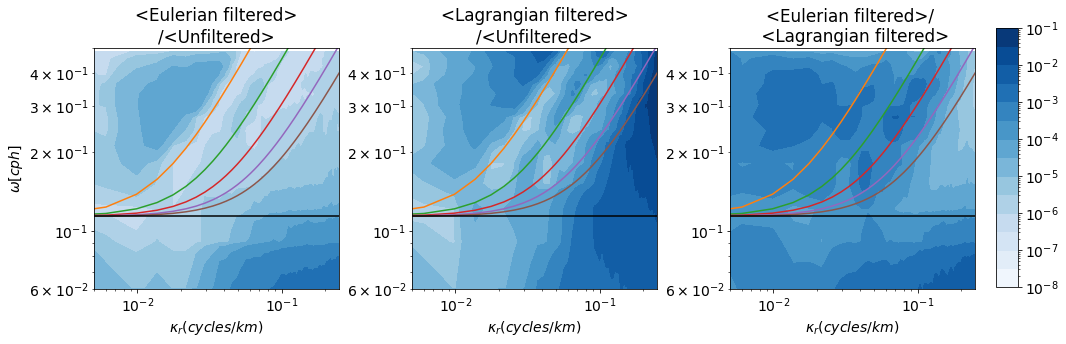

In [108]:
plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-8,-1,15)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso_eul/ps_iso_unfilt),lev,norm=LogNorm(), cmap='Blues',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('<Eulerian filtered>\n/<Unfiltered>')
plt.axhline(-fm/np.pi*3600,color='k')

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso/ps_iso_unfilt),lev,norm=LogNorm(), cmap='Blues',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('<Lagrangian filtered>\n/<Unfiltered>')
plt.axhline(-fm/np.pi*3600,color='k')

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso_eul/ps_iso),lev,norm=LogNorm(), cmap='Blues')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('<Eulerian filtered>/ \n <Lagrangian filtered>')
plt.axhline(-fm/np.pi*3600,color='k')



fig=plt.gcf()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('wavenumber_diff.png')

(0.06, 0.5)

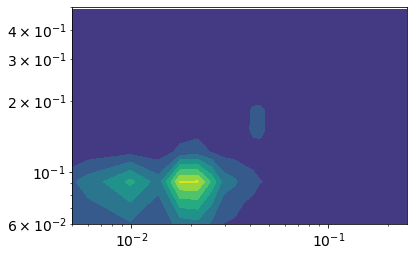

In [52]:
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso_unfilt-ps_iso))
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])

In [94]:
fm

-9.919264063576999e-05

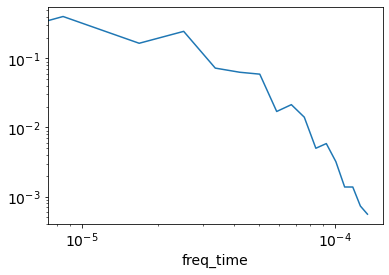

In [47]:
(np.abs(omega)*kr*ps_iso_unfilt).sum('kr').plot()
plt.xscale('log')
plt.yscale('log')

In [293]:
ds = xr.open_zarr(fnames[0])
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)

In [28]:
window_width=30
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)

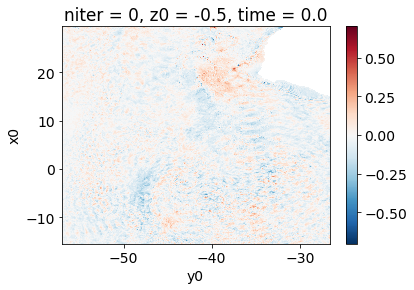

In [34]:
(ds.u-windowed_u).sel(time=0).isel(z0=3).plot()

In [63]:
for fileno in range(0,50):
    print(str(6048+fileno*144))

6048
6192
6336
6480
6624
6768
6912
7056
7200
7344
7488
7632
7776
7920
8064
8208
8352
8496
8640
8784
8928
9072
9216
9360
9504
9648
9792
9936
10080
10224
10368
10512
10656
10800
10944
11088
11232
11376
11520
11664
11808
11952
12096
12240
12384
12528
12672
12816
12960
13104


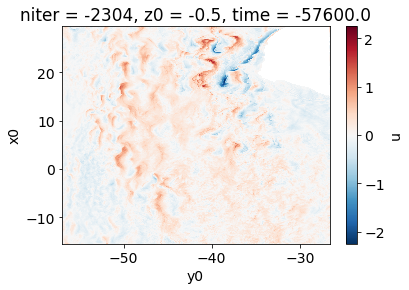

In [103]:
ds.u.isel(time=20).isel(z0=3).plot()

In [136]:
ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048) +'.zarr')
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where((ds.u!=-999).all(dim='time'))

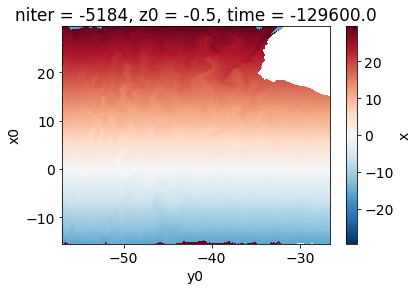

In [139]:
ds.x.isel(time=0).isel(z0=3).plot()

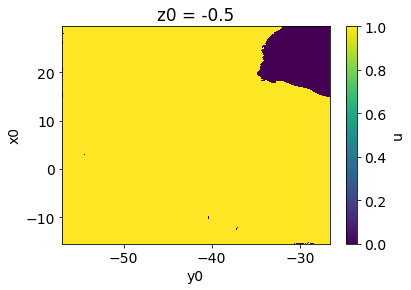

In [135]:
(ds.u!=-999).all(dim='time').isel(z0=3).plot()#.any(dim='time').isel(z0=3).plot()